Using device: cuda
Model path: d:\gankushagra\new-20241107T124416Z-001\cnn\best_model_seg_NEW.pth
Test data path: d:\gankushagra\new-20241107T124416Z-001\cnn\output_images
Checking directory structure for test data...
Label 0:
 - RF dir exists? True -> d:\gankushagra\new-20241107T124416Z-001\cnn\output_images\0\rf
 - ROI dir exists? True -> d:\gankushagra\new-20241107T124416Z-001\cnn\output_images\0\roi
 - Found 96 RF images
 - Found 96 ROI masks

Label 1:
 - RF dir exists? True -> d:\gankushagra\new-20241107T124416Z-001\cnn\output_images\1\rf
 - ROI dir exists? True -> d:\gankushagra\new-20241107T124416Z-001\cnn\output_images\1\roi
 - Found 104 RF images
 - Found 104 ROI masks

Processing test images from output_images/0\rf
Found 96 RF images and 96 ROIs for label 0
Processing test images from output_images/1\rf
Found 104 RF images and 104 ROIs for label 1
Total test samples: 200
Model loaded successfully from best_model_seg_NEW.pth
Running inference on test data...

==== Segmentation

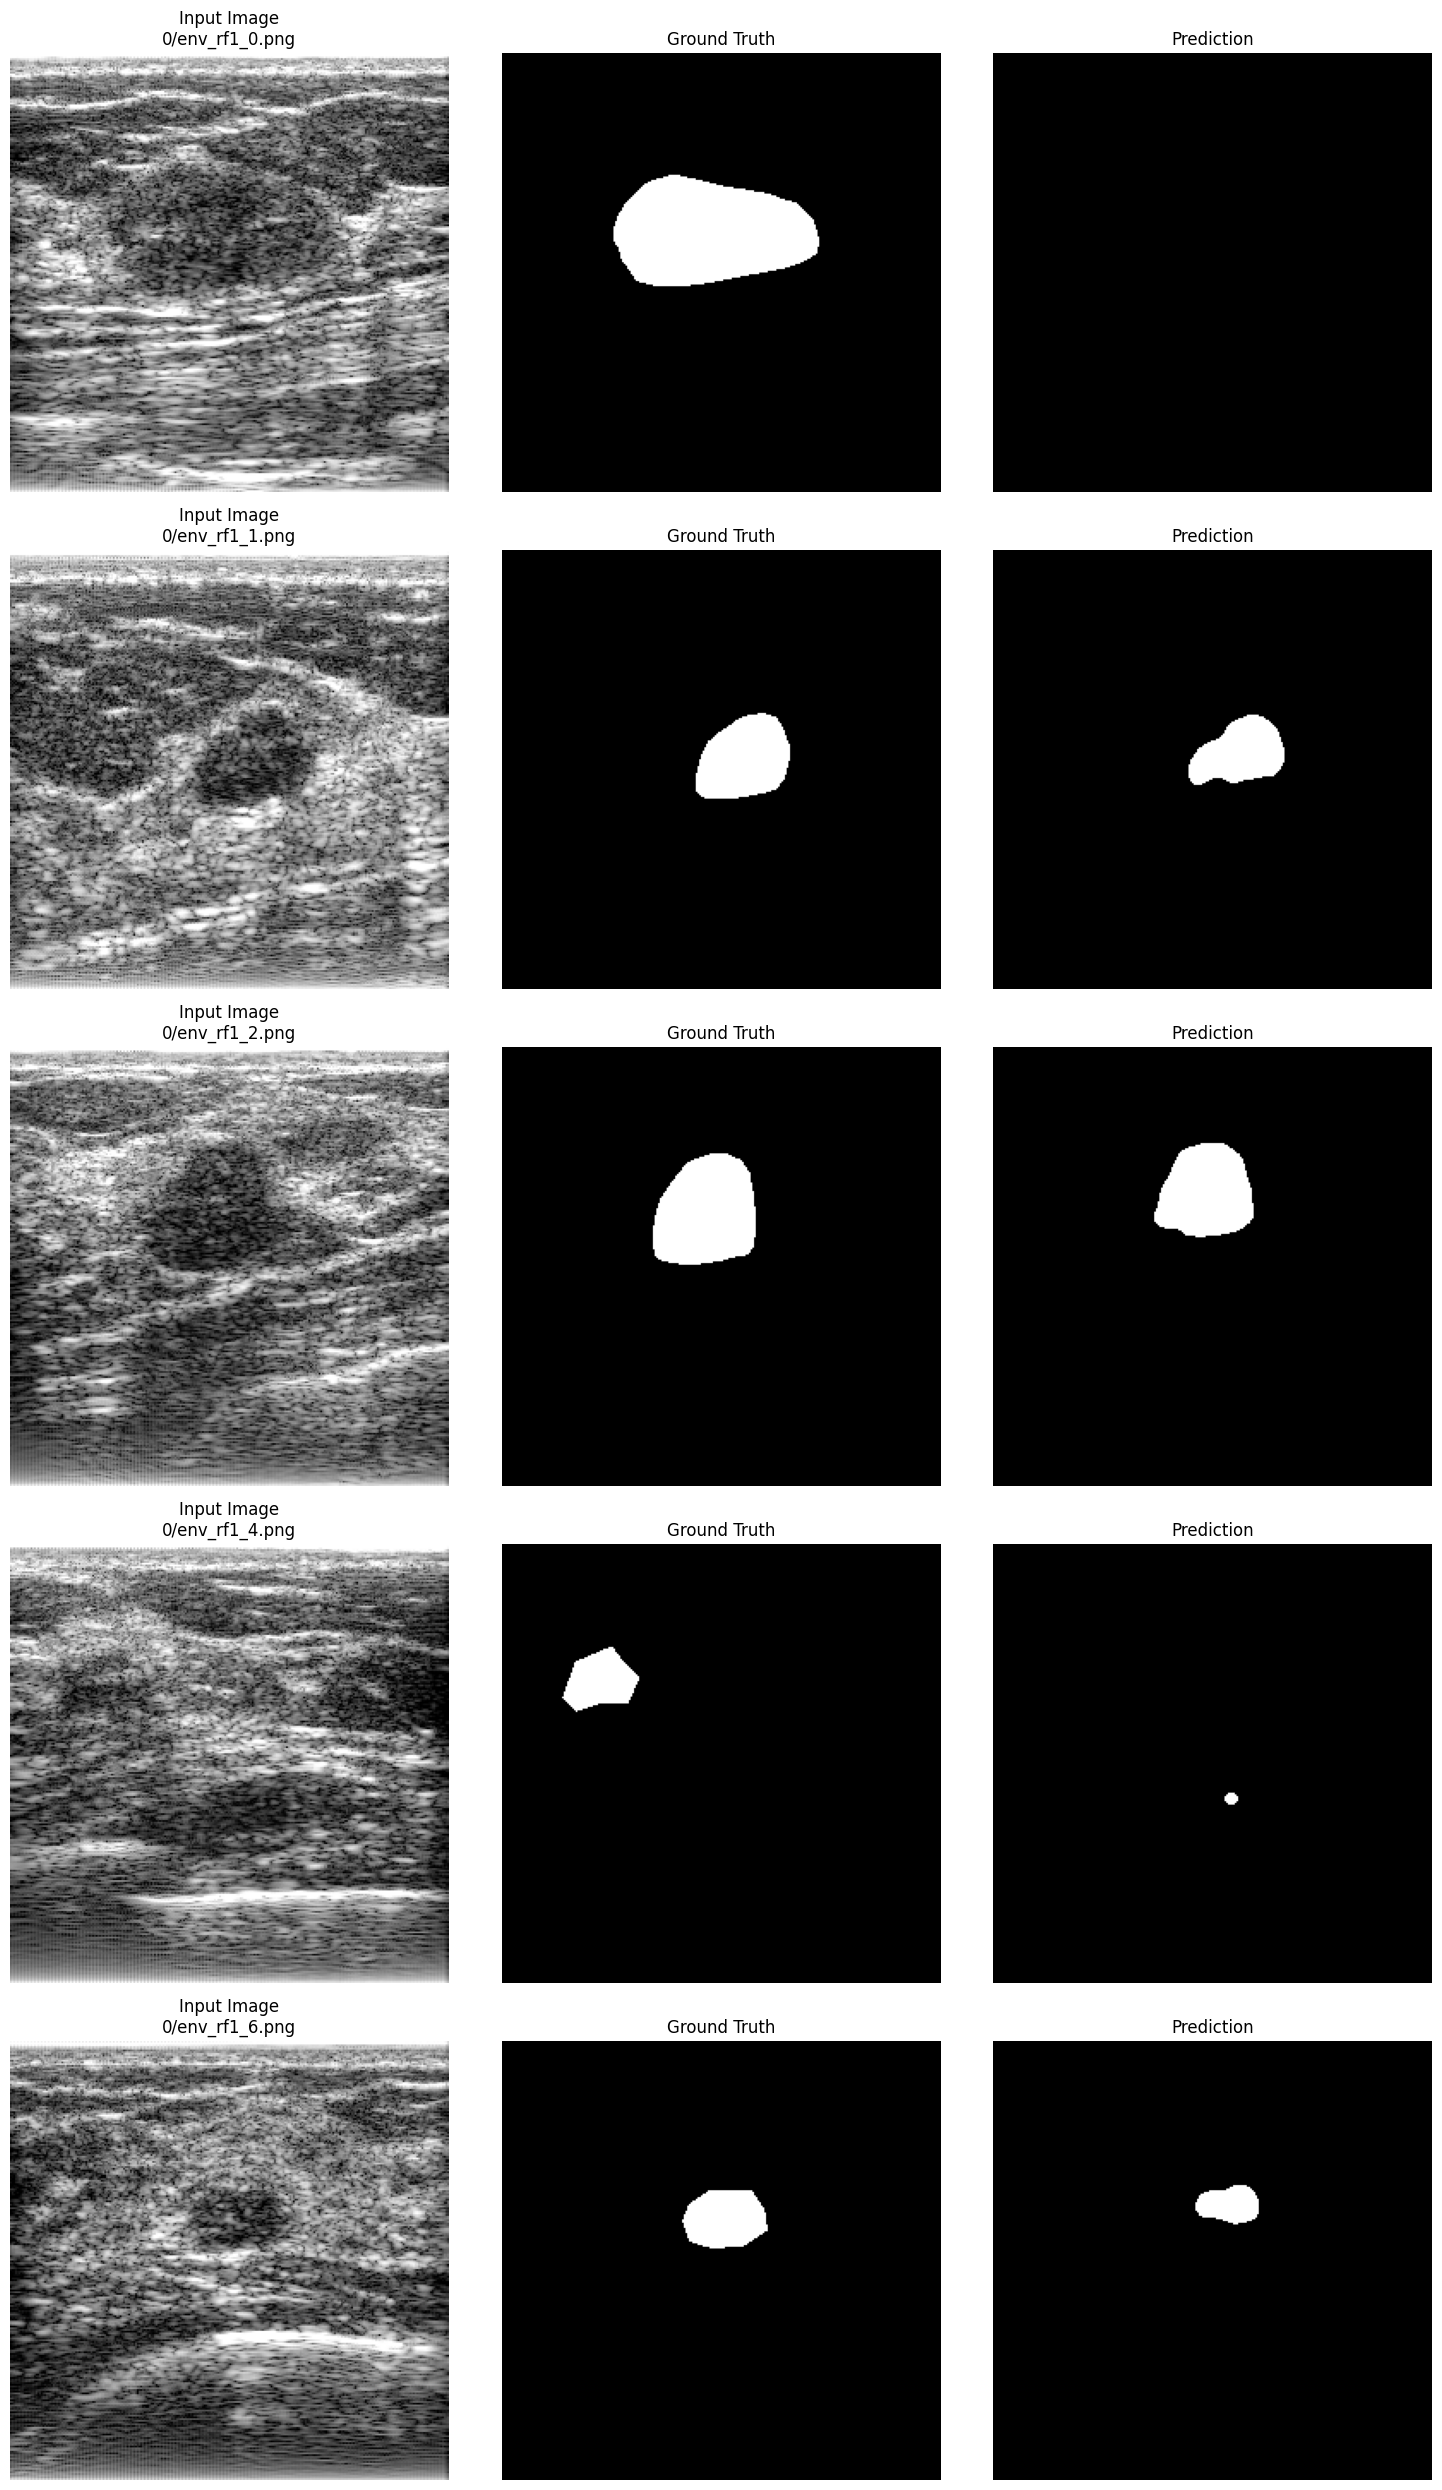

Results saved to test_results.txt


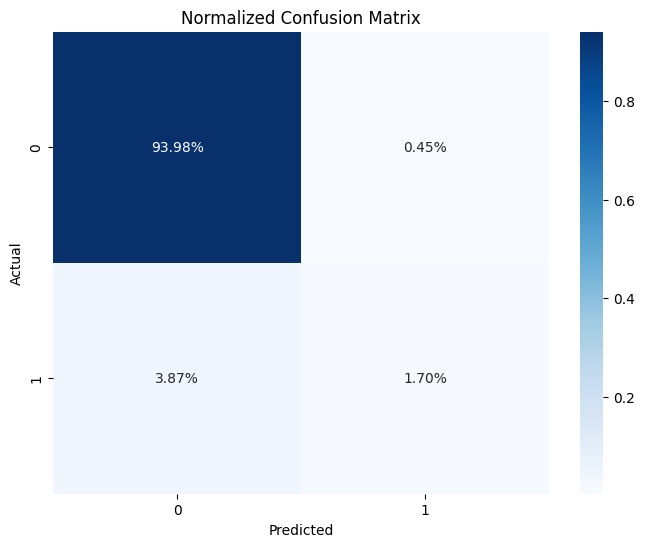

In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
MODEL_PATH = "best_model_seg_NEW.pth"  # Path to the saved model
DATA_PATH = "output_images/"  # Path to the test data
LABELS = ["0", "1"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test Dataset Class
class UltrasoundTestDataset(Dataset):
    def __init__(self, data_path):
        self.rf_images = []
        self.roi_masks = []
        self.file_names = []
        valid_extensions = ('.png', '.jpg', '.jpeg')
        
        for label in LABELS:
            rf_path = os.path.join(data_path, label, "rf")
            roi_path = os.path.join(data_path, label, "roi")
            
            # Check if directories exist
            if not os.path.exists(rf_path):
                print(f"Warning: RF directory not found: {os.path.abspath(rf_path)}")
                continue
                
            if not os.path.exists(roi_path):
                print(f"Warning: ROI directory not found: {os.path.abspath(roi_path)}")
                continue
            
            print(f"Processing test images from {rf_path}")
            
            rf_files = natsorted([f for f in os.listdir(rf_path) if f.lower().endswith(valid_extensions)])
            roi_files = natsorted([f for f in os.listdir(roi_path) if f.lower().endswith(valid_extensions)])

            if len(rf_files) == 0:
                print(f"Warning: No valid images found in {rf_path}")
                
            if len(roi_files) == 0:
                print(f"Warning: No valid ROIs found in {roi_path}")
                
            print(f"Found {len(rf_files)} RF images and {len(roi_files)} ROIs for label {label}")
            
            # Make sure we only process files that have both image and ROI
            for rf_file, roi_file in zip(rf_files, roi_files):
                rf_path_full = os.path.join(rf_path, rf_file)
                roi_path_full = os.path.join(roi_path, roi_file)
                
                rf_img = cv2.imread(rf_path_full, cv2.IMREAD_GRAYSCALE)
                roi_img = cv2.imread(roi_path_full, cv2.IMREAD_GRAYSCALE)

                if rf_img is None:
                    print(f"Warning: Could not read image: {rf_path_full}")
                    continue
                    
                if roi_img is None:
                    print(f"Warning: Could not read ROI: {roi_path_full}")
                    continue

                rf_img = cv2.resize(rf_img, IMG_SIZE)
                roi_img = cv2.resize(roi_img, IMG_SIZE)
                roi_img = (roi_img > 127).astype(np.float32)  # Threshold to binary

                self.rf_images.append(rf_img)
                self.roi_masks.append(roi_img)
                self.file_names.append(f"{label}/{rf_file}")

    def __len__(self):
        return len(self.rf_images)

    def __getitem__(self, idx):
        img = torch.tensor(self.rf_images[idx], dtype=torch.float32).unsqueeze(0) / 255.0
        mask = torch.tensor(self.roi_masks[idx], dtype=torch.float32).unsqueeze(0)
        return img, mask, self.file_names[idx]

# Improved U-Net (same as your training code)
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        d4 = self.up4(e4)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.final(d2)

# Metrics
def calculate_metrics(TP, TN, FP, FN):
    eps = 1e-10
    return {
        'Accuracy': (TP + TN) / (TP + TN + FP + FN + eps),
        'Recall/Sensitivity': TP / (TP + FN + eps),
        'Specificity': TN / (TN + FP + eps),
        'Precision': TP / (TP + FP + eps),
        'F1-Score': (2 * TP) / (2 * TP + FP + FN + eps),
        'Dice': (2 * TP) / (2 * TP + FP + FN + eps),
        'IoU/Jaccard': TP / (TP + FP + FN + eps)
    }

# Function to visualize predictions
def visualize_predictions(images, masks, predictions, filenames, num_samples=5):
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Input Image\n{filenames[i]}")
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("prediction_results.png")
    plt.show()

# Function to save analysis results to file
def save_results(metrics, cm, class_metrics, save_path="test_results.txt"):
    with open(save_path, "w") as f:
        f.write("==== SEGMENTATION TEST RESULTS ====\n\n")
        
        f.write("=== Overall Metrics ===\n")
        for metric_name, value in metrics.items():
            f.write(f"{metric_name}: {value:.4f}\n")
        
        f.write("\n=== Confusion Matrix ===\n")
        f.write(f"TN: {cm[0, 0]}, FP: {cm[0, 1]}\n")
        f.write(f"FN: {cm[1, 0]}, TP: {cm[1, 1]}\n")
        
        f.write("\n=== Per-Class Metrics ===\n")
        for label, metrics_dict in class_metrics.items():
            f.write(f"Class {label}:\n")
            for metric_name, value in metrics_dict.items():
                f.write(f"  {metric_name}: {value:.4f}\n")

    print(f"Results saved to {save_path}")

def test_model():
    # Check if model file exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at {MODEL_PATH}")
        return

    # Load test dataset
    test_dataset = UltrasoundTestDataset(DATA_PATH)
    
    if len(test_dataset) == 0:
        print("Error: No test data found. Please check your directory structure.")
        return
        
    print(f"Total test samples: {len(test_dataset)}")
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load model
    model = ImprovedUNet().to(device)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"Model loaded successfully from {MODEL_PATH}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return
    
    # Testing
    model.eval()
    
    all_preds = []
    all_masks = []
    all_images = []
    all_filenames = []
    total_pixels = 0
    TP = TN = FP = FN = 0
    
    print("Running inference on test data...")
    
    with torch.no_grad():
        for images, masks, filenames in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = (outputs > 0.5).float()
            
            # Calculate pixel-wise metrics
            tp = (preds * masks).sum().item()
            tn = ((1 - preds) * (1 - masks)).sum().item()
            fp = (preds * (1 - masks)).sum().item()
            fn = ((1 - preds) * masks).sum().item()
            
            TP += tp
            TN += tn
            FP += fp
            FN += fn
            total_pixels += masks.numel()
            
            # Save for visualization
            all_preds.extend(preds.cpu().numpy())
            all_masks.extend(masks.cpu().numpy())
            all_images.extend(images.cpu().numpy())
            all_filenames.extend(filenames)
    
    # Calculate overall metrics
    metrics = calculate_metrics(TP, TN, FP, FN)
    
    # Create confusion matrix
    cm = np.array([[TN, FP], [FN, TP]])
    
    # Calculate per-class metrics (background vs foreground)
    class_metrics = {
        "background": {
            "Precision": TN / (TN + FN + 1e-10),
            "Recall": TN / (TN + FP + 1e-10),
            "F1-Score": (2 * TN) / (2 * TN + FP + FN + 1e-10)
        },
        "foreground": {
            "Precision": TP / (TP + FP + 1e-10),
            "Recall": TP / (TP + FN + 1e-10),
            "F1-Score": (2 * TP) / (2 * TP + FP + FN + 1e-10)
        }
    }
    
    # Print results
    print("\n==== Segmentation Test Results ====")
    print(f"Total test images: {len(test_dataset)}")
    print(f"Total pixels evaluated: {total_pixels}")
    
    print("\n=== Confusion Matrix ===")
    print(f"TN: {TN}, FP: {FP}")
    print(f"FN: {FN}, TP: {TP}")
    
    print("\n=== Overall Metrics ===")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Visualize some predictions
    visualize_predictions(all_images, all_masks, all_preds, all_filenames)
    
    # Save results to file
    save_results(metrics, cm, class_metrics)
    
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    plt.show()
    
    return metrics

def check_directories():
    print("Checking directory structure for test data...")
    
    for label in LABELS:
        rf_dir = os.path.join(DATA_PATH, label, "rf")
        roi_dir = os.path.join(DATA_PATH, label, "roi")
        
        print(f"Label {label}:")
        print(f" - RF dir exists? {os.path.exists(rf_dir)} -> {os.path.abspath(rf_dir)}")
        print(f" - ROI dir exists? {os.path.exists(roi_dir)} -> {os.path.abspath(roi_dir)}")
        
        if os.path.exists(rf_dir):
            rf_count = len([f for f in os.listdir(rf_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f" - Found {rf_count} RF images")
        
        if os.path.exists(roi_dir):
            roi_count = len([f for f in os.listdir(roi_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f" - Found {roi_count} ROI masks")
        
        print()

if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Model path: {os.path.abspath(MODEL_PATH)}")
    print(f"Test data path: {os.path.abspath(DATA_PATH)}")
    
    # Check if directories exist
    check_directories()
    
    # Ask user if they want to proceed
    proceed = input("Do you want to proceed with testing? (y/n): ")
    if proceed.lower() in ['y', 'yes']:
        test_model()
    else:
        print("Testing cancelled.")